**Анализ результатов A/B-теста.**

Задача 
 * Провести оценку результатов A/B-теста:
   * Оценить корректность проведения теста;
   * Проанализировать результаты теста.
 * Оценить изменения, связанные с внедрением улучшенной рекомендательной системы;

Для выполнения задач будем использовать четыре файла с данными final_ab_events.csv, ab_project_marketing_events.csv, final_ab_new_users.csv, final_ab_participants.csv, которые содержат следующие данные:

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

Выполнять задание мы будем в соответствии с **техническим заданием:**

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

**Последовательность действий по выполнению проекта:**  

I. Загрузить и изучить данные:
  - импорт необходимых библиотек для работы;
  - загрузка данных и получение общей информации о них;
  - краткий вывод о имеющихся данных.  
  
II. Предобработка данных:
  - проверить название колонок и тип данных в столбцах;
  - сделать проверку на наличие дубликатов;
  - поиск и обработка пропущенных значений;
  - проверить данные на наличие выбросов и аномальных значений;
  - проверить данные на соответствие техническому заданию;
  - проверить условие о том, что число участников должно быть 6000 и это 15% от общего числа зарегистрованных с  7 по 21 декабря из стран ЕС;
  - проверить время проведения теста, совпадает ли оно с маркетинговыми и другими активностями;
  - проверить количество дней, занявшее у каждого пользователя с момента регистрации до первого действия;
  - выводы по этапу предобработки данных.  
  
III. Исследовательский анализ данных:   
  - рассчитать количество событий на пользователя и посмотреть на распределение по группам;
  - посмотреть на распределение событий в группах по дням;
  - построить и проанализировать воронку событий;
  - выводы по этапу исследовательского анализа данных.  
  
IV. Оценка результатов A/B тестирования:
  - Проверка статистической разницы долей z-критерием;
  - Выводы.


## Загрузка и изучение данных.

### Импорт необходимых библиотек.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
import math as mth
from scipy import stats as st
import numpy as np
import plotly.io as pio

### Загрузка данных и получение общей информации о них.

In [2]:
try:
    marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
    events = pd.read_csv('/datasets/final_ab_events.csv')
    new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
    participants = pd.read_csv('/datasets/final_ab_participants.csv')
except:
    marketing_events = pd.read_csv('C:\datasets\ab_project_marketing_events.csv')
    events = pd.read_csv('C:\datasets\final_ab_events.csv')
    new_users = pd.read_csv('C:\datasets\final_ab_new_users.csv')
    participants = pd.read_csv('C:\datasets\final_ab_participants.csv')

In [3]:
for df in [marketing_events,events,new_users,participants]:
    print()
    display(df.head())
    print()
    print(df.info())

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None



,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None



,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None



,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
None


### Выводы о имеющихся данных.

* В таблицах marketing_events,events и new_users присутствуют колонки с датами и в них неверный тип данных - это будет необходимо исправить;
* В названиях колонок соблюдён единый стиль;
* В таблице events столбце details, судя по всему, есть пропуски - необходимо будет проверить это на этапе предобработки данных.

## Предобработка данных и проверка на соответствие ТЗ.

### Изменение типа данных в столбцах.

Проверим тип данных в интересующих нас таблицах.

In [4]:
print(marketing_events.dtypes)
print()
print(events.dtypes)
new_users.dtypes

name         object
regions      object
start_dt     object
finish_dt    object
dtype: object

user_id        object
event_dt       object
event_name     object
details       float64
dtype: object


user_id       object
first_date    object
region        object
device        object
dtype: object

У нас есть 4 колонки с датами и типом данных object, изменим тип данных на datetime.

In [5]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])
events['event_dt'] = pd.to_datetime(events['event_dt'])
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

Проверим тип данных после внесенных изменений.

In [6]:
print(marketing_events.dtypes)
print()
print(events.dtypes)
new_users.dtypes

name                 object
regions              object
start_dt     datetime64[ns]
finish_dt    datetime64[ns]
dtype: object

user_id               object
event_dt      datetime64[ns]
event_name            object
details              float64
dtype: object


user_id               object
first_date    datetime64[ns]
region                object
device                object
dtype: object

Теперь тип данных во всех колонках верный.

### Проверка на наличие дубликатов.

In [7]:
print('Количество дубликатов в таблице marketing_events:',sum(marketing_events.duplicated()))
print('Количество дубликатов в таблице events:',sum(events.duplicated()))
print('Количество дубликатов в таблице new_users:',sum(new_users.duplicated()))
print('Количество дубликатов в таблице participants:',sum(participants.duplicated()))

Количество дубликатов в таблице marketing_events: 0
Количество дубликатов в таблице events: 0
Количество дубликатов в таблице new_users: 0
Количество дубликатов в таблице participants: 0


Как видно, в данных нет дубликатов.

### Поиск и обработка пропущенных значений.

In [8]:
for df in [marketing_events,events,new_users,participants]:
    print(df.isna().sum())
    print()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

user_id       0
first_date    0
region        0
device        0
dtype: int64

user_id    0
group      0
ab_test    0
dtype: int64



В таблице events колонке details есть пропуски и их очень много - это дополнительные данные о событии, проверим какие события представлены и сколько пропусков соответствует каждому.

In [9]:
print('Количество пропусков в столбце details таблицы events:', events['details'].isna().sum())

Количество пропусков в столбце details таблицы events: 377577


In [10]:
events.groupby('event_name')['details'].count()

event_name
login               0
product_cart        0
product_page        0
purchase        62740
Name: details, dtype: int64

По событиям 'product_cart', 'product_page', 'login' данных в столбце details нет. Пропуски по этим событиям можно объяснить тем, что нет числового выражения, способного описать эти события, в отличие от этапа покупки (purchase), где есть стоимость покупки. Будем учитывать эту информацию при дальнейшем анализе, но заменять пропуски ничем не будем, чтобы не искажать данные.

### Проверка на наличие выбросов и аномальных значений.

Начнем проверять таблицы по порядку. Первую таблицу загрузим и оценим полностью, т.к. она маленькая.

In [11]:
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Никаких странных или подозрительных даных в этой таблице нет.

In [12]:
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


В таблице с событиями проверим столбец с датой и описанием действия.

In [13]:
events['details'].describe()

count    62740.000000
mean        23.877631
std         72.180465
min          4.990000
25%          4.990000
50%          4.990000
75%          9.990000
max        499.990000
Name: details, dtype: float64

In [14]:
events['details'].value_counts()

4.99      46362
9.99       9530
99.99      5631
499.99     1217
Name: details, dtype: int64

Так как все дополнительные данные соответствуют действию покупки они хранят стоимость покупки. В наших данных всего 4 цены - 4.99, 9.99, 99.99 и 499.99. По всей видимости у интернет-магазина узкий ассортимент продукции, либо, возможно, это 4 варианта подписки.

In [15]:
print('Минимальная дата в данных:',events['event_dt'].min())
print('Максимальная дата в данных:',events['event_dt'].max())

Минимальная дата в данных: 2020-12-07 00:00:33
Максимальная дата в данных: 2020-12-30 23:36:33


В нашем распоряжении данные по событиям с 7 декабря 2020 года по 30 декабря 2020 года, хотя в техническом задании указана дата остановки тесте 4 января 2021. По всей видимости, у нас нет данных за 5 дней.

In [16]:
new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Проверим столбец с датой и распределением пользователей по региону.

In [17]:
new_users['region'].value_counts()

EU           46270
N.America     9155
CIS           3155
APAC          3153
Name: region, dtype: int64

Подавляющее большинство пользователей из Европейского союза.

In [18]:
print('Минимальная дата в данных:',new_users['first_date'].min())
print('Максимальная дата в данных:',new_users['first_date'].max())

Минимальная дата в данных: 2020-12-07 00:00:00
Максимальная дата в данных: 2020-12-23 00:00:00


В нашем распоряжении данные о пользователях зарегистрированных с 7 декабря по 23 декабря - этот временной промежуток немного больше того, что указан в ТЗ.

In [19]:
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


В последней таблице, с данными о пользователях участвующих в тестах, посмотрим на распределение в столбцах с группой и тестом.

In [20]:
participants['group'].value_counts()

A    9655
B    8613
Name: group, dtype: int64

Примерно на 10% больше пользователей в группе контрольной группе А, чем в тестовой B.

In [21]:
participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

В разделение по тестам еще большее разделение, практически в два раза. Тест, который нам интересен recommender_system_test и в нем приняло участие 6701 пользователь.

### Проверка данных на соответствие техническому заданию.

*1) Название теста: recommender_system_test*  

Как мы выяснили ранее, такой тест есть в наших данных и в нем приняло участие 6701 пользователь.  

*2) группы: А — контрольная, B — новая платёжная воронка*  

В наших данных присутствует информация об этих двух группах.  

*3) дата запуска: 2020-12-07*

В наших таблицах хранится информация о зарегистрированных пользователях и действиях с 2020-12-07.

*4) дата остановки набора новых пользователей: 2020-12-21*

В таблице с регистрацией новых пользователей данные до 23 декабря включительно, чтобы датасет соответствовал ТЗ удалим данные о пользователях зарегистрированных 22 и 23 декабря.

In [22]:
new_users

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


In [23]:
print('Количество пользователей зарегистрированных 22 и 23 декабря:',len(new_users[new_users['first_date']> '2020-12-21']))

Количество пользователей зарегистрированных 22 и 23 декабря: 5263


При удалении, мы потеряем чуть менее 10% данных о зарегистрированных пользователях.

In [24]:
new_users = new_users[new_users['first_date'] < '2020-12-22'].reset_index(drop=True)
new_users

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
56465,1DB53B933257165D,2020-12-20,EU,Android
56466,538643EB4527ED03,2020-12-20,EU,Mac
56467,7ADEE837D5D8CBBD,2020-12-20,EU,PC
56468,1C7D23927835213F,2020-12-20,EU,iPhone


*4) дата остановки теста: 2021-01-04*  

В наших данных имеется информации о событиях по 30 декабря, т.е. мы не выйдем за рамки ТЗ, однако, имеем период меньше чем указан.


Далее, отдельно проверим три условия соответствия данных ТЗ.

### Проверка условия о том, что число участников должно быть 6000 и это 15% от общего числа зарегистрованных с  7 по 21 из стран ЕС.

In [25]:
new_users.groupby('region').agg({'user_id':'nunique'})

,user_id
region,
APAC,2883
CIS,2900
EU,42340
N.America,8347


Большинство зарегистрированных пользователей из ЕС, однако, нам нужно посмотреть сколько человек из них учавствуют в тесте.
С 7 по 21 декабря было зарегистрированы 42340 человек из Европы.
Объединим таблицы с участвующими в тесте и зарегистрированными пользователями.

In [26]:
ab_test_users = participants.merge(new_users,on='user_id')
ab_test_users

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,DABC14FDDFADD29E,A,interface_eu_test,2020-12-08,EU,Mac
4,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
...,...,...,...,...,...,...
17261,1D302F8688B91781,B,interface_eu_test,2020-12-15,EU,PC
17262,3DE51B726983B657,A,interface_eu_test,2020-12-07,EU,Android
17263,F501F79D332BE86C,A,interface_eu_test,2020-12-17,EU,Mac
17264,63FBE257B05F2245,A,interface_eu_test,2020-12-20,EU,Android


Так как по ТЗ нам необходимо, чтобы в тесте участвовало 6000 пользователей из Европы и это составляло 15% от зарегистрированых пользователей в период с 7 по 21 из ЕС, то уберем пользователей из других регионов. Также проверим сколько таких пользователей проходили именно наш тест.

In [27]:
ab_test_users = ab_test_users[ab_test_users['region']=='EU']
ab_test_users['ab_test'].value_counts()

interface_eu_test          10565
recommender_system_test     6351
Name: ab_test, dtype: int64

In [28]:
print('Доля новых пользователей учавствующих в тесте, от всех новых пользователей из Евросоюза:',
     ab_test_users[ab_test_users['ab_test']=='recommender_system_test'].shape[0]/
     new_users[new_users['region']=='EU'].shape[0]
     )

Доля новых пользователей учавствующих в тесте, от всех новых пользователей из Евросоюза: 0.15


В итоге получается, что в нашем тесте учавствует 6351 человек из Евросоюза и это составляет 15% от общего числа пользователей из Евросоюза, зарегистрированных в период с 7 по 21 декабря. Два пункта ТЗ выполнены, дальнейшее отсеивание пользователей приведет к нарушению условий ТЗ.

### Проверка времени проведения теста. Совпадает ли оно с маркетинговыми и другими активностями.

Время проведения теста с 2020-12-07 по 2021-01-04, хотя фактически в нашем распоряжении данные по 2020-12-30.

Проверим, проводились ли маркетинговые компании в это время.

In [29]:
marketing_events[(marketing_events['finish_dt'] > '2020-12-06') & (marketing_events['finish_dt'] <= '2021-01-04')]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


In [30]:
marketing_events[(marketing_events['start_dt'] > '2020-12-06') & (marketing_events['start_dt'] <= '2021-01-04')]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Компания CIS New Year Gift Lottery проводилась для региона CIS и не могла повлиять на поведение пользователей из Европы.  
Christmas&New Year Promo проводилась для региона EU с 25 декабря по 3 января 2021 года. Период с 25 декабря по 30 декабря совпадает с проведением нашего теста.

In [31]:
events

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


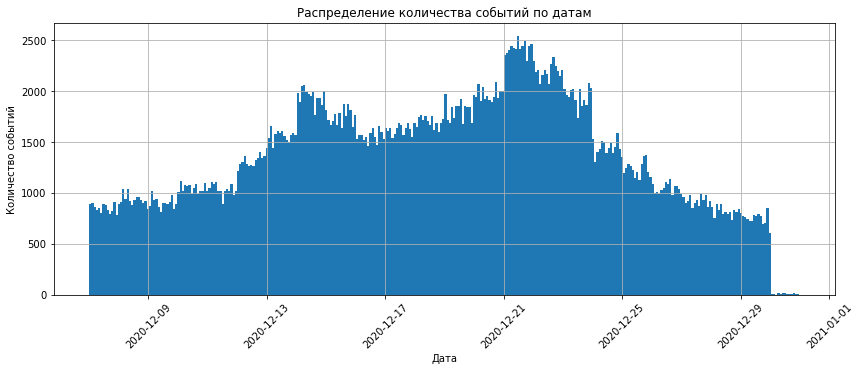

In [32]:
#Построим гистрограмму количества событий по времени
plt.figure(figsize=(14,5))
plt.hist(events['event_dt'],bins=14*23)
plt.title('Распределение количества событий по датам')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Мы видим, что глобально, пик активности всех пользователей приходится на отрезок с 14 декабря по 23 декабря, а, начиная с 25 количество событий неуклонно снижается, и достигает своих минимальных значений к 30 декабря. Учитывая вышеописанное и то, что дальнейшая фильтрация приведет к нарушению ТЗ по минимальному количеству участников в тесте, мы не будем считать что, маркетинговая компания оказала влияние на поведение пользователей и не будем удалять данные за этот период.

### Проверим есть ли пересечения с конкурирующим тестом и есть ли пользователи, участвующие в двух группах теста одновременно. Проверим равномерность распределения по тестовым группам и правильность их формирования.

Посмотрим сколько пользователей участвовали в тестах в разбивке по группам.

In [33]:
ab_test_users.groupby(['ab_test','group']).agg({'user_id':'nunique'})

user_id
ab_test                 group         
interface_eu_test       A         5342
                        B         5223
recommender_system_test A         3634
                        B         2717

Распределение по группам нашего теста показывает перевес по количеству пользователей в пользу группы A - 3634 человека, против B - 2717 человек.

Проверим, есть ли пользователи участвующие в нашем тесте и находящиеся одновременно в двух группах.

In [34]:
first_test = ab_test_users.query('ab_test == "recommender_system_test"')
len(first_test.groupby('user_id')['group'].nunique().reset_index().query('group > 1'))

0

Среди наших данных нет пользователей, участвующих в нашем тесте, находящихся в двух группах одновременно.

Теперь проверим, есть ли пересечения нашего с конкурирующим тестом. В первую очередь, нам интересны пользователи группы B участвующие во втором тесте, т.к. они видели уже сделанные изменения в работе сайта.  
Посмотрим, сколько пользователей из нашего теста учавствовала во втором тесте из группы B.

In [35]:
second_test = ab_test_users.query('ab_test == "interface_eu_test"')
second_test.head()

,user_id,group,ab_test,first_date,region,device
3,DABC14FDDFADD29E,A,interface_eu_test,2020-12-08,EU,Mac
5,04988C5DF189632E,A,interface_eu_test,2020-12-14,EU,iPhone
13,B3A2485649E4A012,A,interface_eu_test,2020-12-09,EU,iPhone
29,EAFB9027A27D510C,A,interface_eu_test,2020-12-07,EU,Android
34,5D5E6EE92AF6E9E0,B,interface_eu_test,2020-12-21,EU,Android


In [36]:
second_test_b_group = second_test.query('group == "B"').user_id.unique()
second_test_b_in_first_test = first_test.query('user_id in @second_test_b_group').groupby('group').agg({'user_id':'nunique'})
second_test_b_in_first_test

,user_id
group,
A,439
B,344


Получается, что пользователи второго теста группы B участвовали в нашем тесте в группе A 439 человек, в группе B 344.

Посмотрим на доли этих пользователей от всех участников нашего теста в разбивке по группам.

In [37]:
print('Доля участников второго теста группы B в нашем тесте группы A:',
     second_test_b_in_first_test.loc['A','user_id']/len(first_test[first_test['group']=='A']))
print('Доля участников второго теста группы B в нашем тесте группы B:',
     second_test_b_in_first_test.loc['B','user_id']/len(first_test[first_test['group']=='B']))

Доля участников второго теста группы B в нашем тесте группы A: 0.12080352228948817
Доля участников второго теста группы B в нашем тесте группы B: 0.12661023187338977


Соотношение пользователей второго теста группы B от общего числа пользователей по группам в нашем тесте одинаковое, около 12%,  т.е. эти пользователи в равной степени могли повлиять на поведение групп в нашем тесте, поэтому данное пересечение, скорее всего, не будет влиять на достоверность нашего A/B теста.

### Сколько дней прошло со дня регистрации до первого действия для каждого пользователя.

Так как по ТЗ нам нужно оценить эффект от новвоведений на горизонте 14 дней с момента регистрации, крайний день регистрации пользователя учитываемый в тесте 21 декабря, а данные о событиях у нас по 30 декабря, то получается, что наш горизонт событий сужается до 9 дней. Нам важно, чтобы все пользователи с момента регистрации совершили свое первое действие в течение 9 дней, т.к. именно оно будет учитываться в воронке событий и это важно для рассчёта конверсии. Проверим это. 

Для проведения дальнейшего анализа данных, соединим таблицу с пользователями и таблицу с событиями.
Удалим из таблицы с пользователями информацию по конкурирующему тесту.

In [38]:
ab_test_users = ab_test_users.query('ab_test == "recommender_system_test"').reset_index(drop=True)

In [39]:
final_ab_test = events.merge(ab_test_users, on='user_id')
final_ab_test

,user_id,event_dt,event_name,details,group,ab_test,first_date,region,device
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A,recommender_system_test,2020-12-07,EU,Android
1,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,A,recommender_system_test,2020-12-07,EU,Android
2,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,A,recommender_system_test,2020-12-07,EU,Android
3,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,NaN,A,recommender_system_test,2020-12-07,EU,Android
4,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,NaN,A,recommender_system_test,2020-12-07,EU,Android
...,...,...,...,...,...,...,...,...,...
23415,1484BBF124DB1B18,2020-12-27 10:53:34,login,NaN,A,recommender_system_test,2020-12-21,EU,PC
23416,BEF16764A13AEC34,2020-12-21 03:49:49,login,NaN,B,recommender_system_test,2020-12-21,EU,PC
23417,BEF16764A13AEC34,2020-12-22 18:52:25,login,NaN,B,recommender_system_test,2020-12-21,EU,PC
23418,BEF16764A13AEC34,2020-12-24 22:11:00,login,NaN,B,recommender_system_test,2020-12-21,EU,PC


In [40]:
final_ab_test.groupby('group').agg({'user_id':'nunique'})

,user_id
group,
A,2604
B,877


Мы видим, что из 6351 пользователя, участвоваших в тесте, активность проявили чуть больше половины и участников группы B оказалось существенно меньше, чем участников группы A, 877 против 2604.

Для начала, нам необходимо добавить столбец с датой события в формате datetime.

In [41]:
final_ab_test['event_date']=final_ab_test['event_dt'].dt.date
final_ab_test['event_date']=pd.to_datetime(final_ab_test['event_date'])
final_ab_test

,user_id,event_dt,event_name,details,group,ab_test,first_date,region,device,event_date
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A,recommender_system_test,2020-12-07,EU,Android,2020-12-07
1,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,A,recommender_system_test,2020-12-07,EU,Android,2020-12-09
2,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,A,recommender_system_test,2020-12-07,EU,Android,2020-12-07
3,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,NaN,A,recommender_system_test,2020-12-07,EU,Android,2020-12-08
4,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,NaN,A,recommender_system_test,2020-12-07,EU,Android,2020-12-09
...,...,...,...,...,...,...,...,...,...,...
23415,1484BBF124DB1B18,2020-12-27 10:53:34,login,NaN,A,recommender_system_test,2020-12-21,EU,PC,2020-12-27
23416,BEF16764A13AEC34,2020-12-21 03:49:49,login,NaN,B,recommender_system_test,2020-12-21,EU,PC,2020-12-21
23417,BEF16764A13AEC34,2020-12-22 18:52:25,login,NaN,B,recommender_system_test,2020-12-21,EU,PC,2020-12-22
23418,BEF16764A13AEC34,2020-12-24 22:11:00,login,NaN,B,recommender_system_test,2020-12-21,EU,PC,2020-12-24


Далее, сгруппируем данные по пользователям, оставив 3481 уникальных и оставим столбцы с датой первого действия и датой регистрации. Затем, вычтем столбец с первой датой и датой регистрации, таким образом, получим количество дней прошедших от дня регистрации до первого действия для каждого пользователя.

In [42]:
first_event=final_ab_test.groupby('user_id')[['event_date','first_date']].agg({'event_date':'min','first_date':'min'})
first_event['date_calc'] = first_event['event_date']-first_event['first_date']
first_event['date_calc'].value_counts()

0 days    3467
1 days       4
2 days       4
6 days       2
4 days       1
8 days       1
5 days       1
3 days       1
Name: date_calc, dtype: int64

Как мы видим, почти все пользователи совершили действие в момент регистрации, а максимальное количество дней у одного пользователя, с момента регистрации до первого действия заняло 8 дней, что вписывается в наши рамки определенные 9 днями.

### Выводы по этапу предобработки данных.

* Тип данных в колонках с датой был object была произведена замена типа данных на datetime;
* Проверка на наличие дубликатов показала их отсутствие;
* В столбце details таблицы events были обнаружены пропуски, но ввиду того, что адекватную замену пропуску сделать невозможно, было принято решение пропуски оставить.
* В ходе изучения таблиц на аномалии и выбросы, никаких подозрительных данных обнаружено не было.
* Было проверено соответствие данных техническому заданию. По результатам исследования все пункты технического задания были выполнены;
* Мы установили, что максимальное количество дней, которое прошло с момента регистрации до первого действия составило 8 дней, что вписывается в установленный горизонт 9 дней.



## Исследовательский анализ данных.

### Распределение количества событий на пользователя в группах.

Посмотрим, сколько событий было совершенно в каждой группе.

In [43]:
final_ab_test.groupby('group').agg({'user_id':'count'})

,user_id
group,
A,18309
B,5111


In [44]:
print('Количество событий пользователей группы А:',len(final_ab_test[final_ab_test['group']=='A']))
print('Количество событий пользователей группы B:',len(final_ab_test[final_ab_test['group']=='B']))
print('Среднее количество событий пользователей группы А на 1 пользователя:',
      round((len(final_ab_test[final_ab_test['group']=='A']))/
      (final_ab_test[final_ab_test['group']=='A']['user_id'].nunique())))
print('Среднее количество событий пользователей группы B на 1 пользователя:',
      round((len(final_ab_test[final_ab_test['group']=='B']))/
      (final_ab_test[final_ab_test['group']=='B']['user_id'].nunique())))

Количество событий пользователей группы А: 18309
Количество событий пользователей группы B: 5111
Среднее количество событий пользователей группы А на 1 пользователя: 7
Среднее количество событий пользователей группы B на 1 пользователя: 6


В среднем, на 1 событие больше совершали пользователи из группы A.

Построим гистрограмму количества пользователей по числу событий

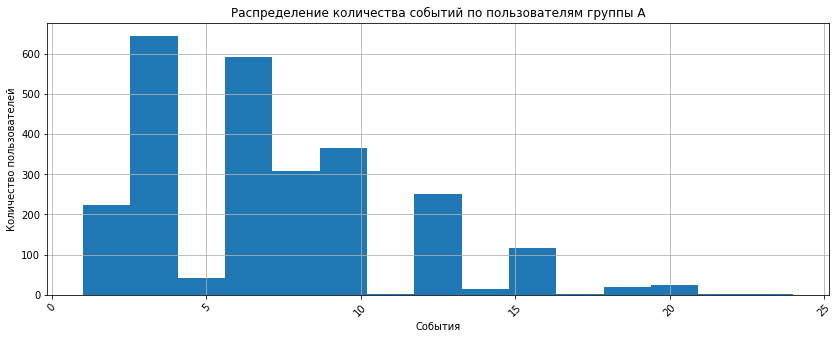

In [45]:
#Построим гистрограмму количества событий по времени для группы А
plt.figure(figsize=(14,5))
plt.hist(final_ab_test[final_ab_test['group']=='A'].groupby('user_id')[['event_name']].count(),bins=15)
plt.title('Распределение количества событий по пользователям группы A')
plt.xlabel('События')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

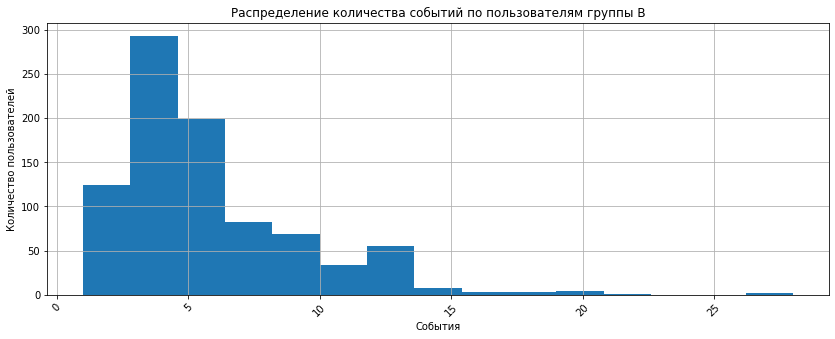

In [46]:
#Построим гистрограмму количества событий по времени для группы B
plt.figure(figsize=(14,5))
plt.hist(final_ab_test[final_ab_test['group']=='B'].groupby('user_id')[['event_name']].count(),bins=15)
plt.title('Распределение количества событий по пользователям группы B')
plt.xlabel('События')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

В группе A пользователем совершается приемущественно совершается от 1 до 10 событий с пиком 6-10 событий,
а в группе B преимущественно совершается от 1 до 6 событий с пиком 4-6 событий.

### Распределение числа событий в группах по дням.

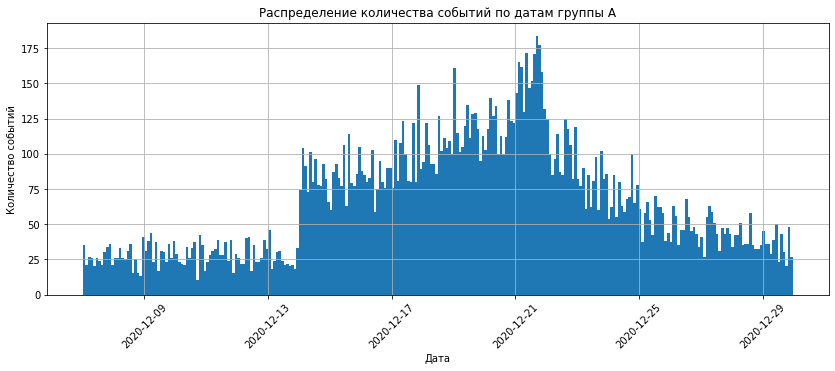

In [47]:
#Построим гистрограмму количества событий группы A
plt.figure(figsize=(14,5))
plt.hist(final_ab_test[final_ab_test['group']=='A']['event_dt'],bins=12*23)
plt.title('Распределение количества событий по датам группы A')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

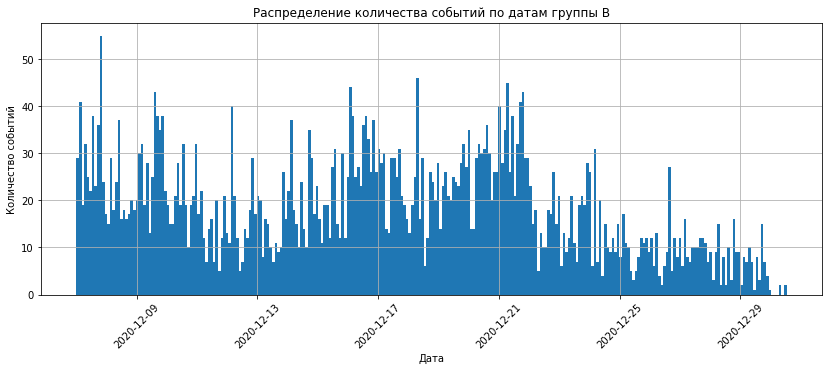

In [48]:
#Построим гистрограмму количества событий группы B
plt.figure(figsize=(14,5))
plt.hist(final_ab_test[final_ab_test['group']=='B']['event_dt'],bins=12*23)
plt.title('Распределение количества событий по датам группы B')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Мы видим, что распределение количества событий по датам в группе А и B разное, у группы А пик приходится с 14 по 24 декабря, а у группы B на 7-9 декабря, 14-15 и 21-22 декабря, при том, после 21 декабря количество существенно снижается.  


Также, отдельно отметим, что после 25 декабря активность снижается - это подтверждает наше мнение о том, что маркетинговая компания, проводимая в этот период, не повлияла на активность пользователей.

### Изучение воронки событий.

In [49]:
print('Уникальных событий в логе:',final_ab_test['event_name'].nunique())
final_ab_test['event_name'].value_counts()

Уникальных событий в логе: 4


login           10595
product_page     6554
purchase         3196
product_cart     3075
Name: event_name, dtype: int64

Всего 4 уникальных событий:
1) login - страница аккаунта, человек зашел под своим логином,           
2) product_page - экран продукта,           
3) product_cart - экран корзины / пользователь добавил продукты в корзину,           
4) purchase - пользователь успешно оплатил заказ.  

Все события последовательны и выстраиваются в логическую цепочку исходя из их количества, однако, немного странно, что событий покупки больше чем событий с корзиной продуктов. Возможно, у пользователей есть выбор купить продукты в один клик, без добавления в корзину, но в дальнейшем, при построении воронки событий мы переместим событие product_cart на 3 место, а purchase опустим на 4.

Визуализируем полученные данные.

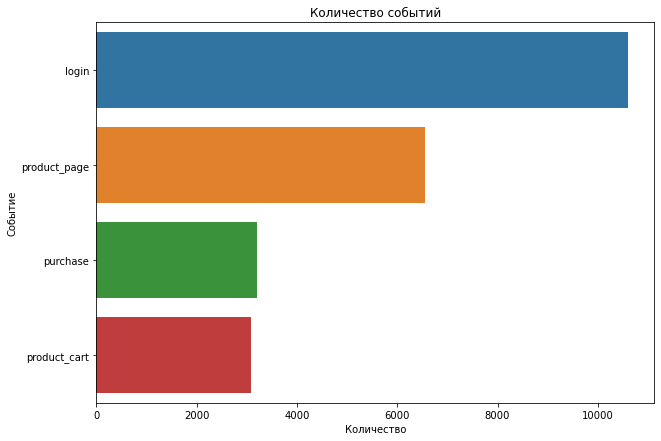

In [50]:
df_event_name=final_ab_test.pivot_table(
    index='event_name', values='group',aggfunc='count').reset_index().set_axis(
    ['event_name','count'],axis='columns'
    ).sort_values(by='count',ascending=False)
plt.figure(figsize=(10,7))
sns.barplot(x='count',y='event_name',data=df_event_name)
plt.title('Количество событий')
plt.xlabel('Количество')
plt.ylabel('Событие')
plt.show()

Найдем число уникальных пользователей, которые совершали разные события и сразу разместим события по их логической цепочке, т.е. оплата будет последняя.

In [51]:
event_name_unique = final_ab_test.pivot_table(index='event_name', 
                                                      values='user_id', 
                                                      columns='group', 
                                                      aggfunc='nunique')

event_name_unique = event_name_unique.sort_values(by = 'A', ascending = False).reset_index().reindex([0,1,3,2])

event_name_unique

group,event_name,A,B
0,login,2604,877
1,product_page,1685,493
3,product_cart,782,244
2,purchase,833,249


Построим воронку событий.

In [52]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Group A',
    y = event_name_unique['event_name'],
    x = event_name_unique['A'],
    textinfo = "value+percent initial+percent previous"))
    

fig.add_trace(go.Funnel(
    name = 'Group B',
    orientation = "h",
    y = event_name_unique['event_name'],
    x = event_name_unique['B'],
    textposition = ["inside", "outside", "outside", "outside"],
    textinfo = "value+percent initial+percent previous"))
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,)
pio.renderers
pio.renderers.default = "svg"

Представим данные, полученные из воронки событий в виде таблицы.  
Найдем долю пользователей совершавших каждое из событий, поделив количество уникальных событий для каждого на общее количество уникальных пользователей по группам.

In [53]:

event_name_unique['share_A'] = round((event_name_unique['A'] / 
                               final_ab_test[final_ab_test['group']=='A']['user_id'].nunique())*100,2).astype(str) + '%'
event_name_unique['share_B'] = round((event_name_unique['B'] / 
                               final_ab_test[final_ab_test['group']=='B']['user_id'].nunique())*100,2).astype(str) + '%'
event_name_unique

group,event_name,A,B,share_A,share_B
0,login,2604,877,100.0%,100.0%
1,product_page,1685,493,64.71%,56.21%
3,product_cart,782,244,30.03%,27.82%
2,purchase,833,249,31.99%,28.39%


Добавим столбцы с количеством клиентов, для расчёта доли пользователей перешедших на следующий этап от числа пользователей на предыдущем.

In [54]:
event_name_unique['for_calculation_A'] = event_name_unique['A'].shift(1, fill_value = event_name_unique['A'].loc[0])
event_name_unique['share_from_previous_A'] = round(
                                                (event_name_unique['A'] / event_name_unique['for_calculation_A'] * 100),2
                                                ).astype(str) + '%'
event_name_unique['for_calculation_B'] = event_name_unique['B'].shift(1, fill_value = event_name_unique['B'].loc[0])
event_name_unique['share_from_previous_B'] = round(
                                                (event_name_unique['B'] / event_name_unique['for_calculation_B'] * 100),2
                                                ).astype(str) + '%'
event_name_unique = event_name_unique.drop(['for_calculation_A','for_calculation_B'],axis=1)
event_name_unique

group,event_name,A,B,share_A,share_B,share_from_previous_A,share_from_previous_B
0,login,2604,877,100.0%,100.0%,100.0%,100.0%
1,product_page,1685,493,64.71%,56.21%,64.71%,56.21%
3,product_cart,782,244,30.03%,27.82%,46.41%,49.49%
2,purchase,833,249,31.99%,28.39%,106.52%,102.05%


Мы видим, что на всех этапах воронки, кроме одного, конверсия выше у пользователей группы A, как по доле от общего числа пользователей по группам, так и от числа пользователей на предыдущем шаге воронки (доля пользователей от количества на предыдущем этапе воронке выше у группы B только на шаге корзины 49.49% против 46.41% у группы А). Также, по воронке событий видно насколько пользователей группы A больше чем пользователей группы B.

### Особенности данных, которые нужно учесть, прежде чем приступать к A/B-тестированию.

* Разное количество пользователей в группе A и B, 2604 против 877 - колоссальная разница;
* В среднем, пользователи группы A совершают на 1 событие больше;
* Шаг login прошли 100% пользователей в обеих группах;
* Конверсия по результатам построения воронки событий выше у группы А на каждом этапе;
* Последний шаг воронки - оплата, содержит больше пользователей чем предыдущий - страница корзины.

## Оценка результатов A/B-тестирования.

Создадим переменную с количеством пользователей в каждой группе.

In [55]:
users = final_ab_test.groupby('group')['user_id'].nunique().reset_index().copy()
users.set_index('group', inplace=True)
users

,user_id
group,
A,2604
B,877


In [56]:
users.loc['A','user_id']

2604

In [57]:
print('Доля группы B от A составляет:',users.loc['B','user_id']/users.loc['A','user_id'])

Доля группы B от A составляет: 0.33678955453149


Разница в количестве участников двух групп очень большая, что вызывает сомнения в успешности проведения A/B теста.

Создадим таблицу с числом уникальных пользователей по каждому событию в разбивке по группам.

In [58]:
funnels = final_ab_test.pivot_table(index='event_name', columns='group',values='user_id',aggfunc='nunique')\
                       .sort_values('A',ascending=False).reset_index()
funnels.set_index('event_name', inplace=True)
funnels

group,A,B
event_name,,
login,2604,877
product_page,1685,493
purchase,833,249
product_cart,782,244


Примем за уровень статистической значимости стандартное значение 0.05 - вероятность совершить ошибку первого рода, т.е. вероятность отклонить нулевую гипотезу, если она истинна составляет 5%.

Сформулируем нулевую и альтернативную гипотезу:  


**Нулевая гипотеза** - Доли уникальных посетителей, побывавших на этапе воронки, одинаковы.  
   
**Альтернативная гипотеза** - Между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница.

Для удобства дальнейшего использования, напишем функцию для Z-критерия, которая будет принимать следующие значения:  
первая группа, вторая группа, событие и уровень статистической значимости.

In [59]:
def z_test(group_1, group_2, event, alpha): 
    p1_event = funnels.loc[event, group_1]
    p2_event = funnels.loc[event, group_2]
    p1_users = users.loc[group_1, 'user_id']
    p2_users = users.loc[group_2, 'user_id']
    p1 = p1_event / p1_users
    p2 = p2_event / p2_users
    p_combined = (p1_event + p2_event) / (p1_users + p2_users)
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / p1_users + 1 / p2_users))
                                                                                                  
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
            
    print(f'Проверка для групп {group_1} и {group_2}, событие: {event}, p-значение: {p_value}')
    
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу о равенстве долей уникальных посетителей, побывавших на этапе воронки")
        print('')
    else:
        print("Не получилось отвергнуть нулевую гипотезу о равенстве долей уникальных посетителей, побывавших на этапе воронки")
        print('')

Создадим цикл для подачи аргументов в функцию и сравним группы A и B

In [60]:
for event in funnels.index:
    z_test('A','B', event, 0.05)

Проверка для групп A и B, событие: login, p-значение: nan
Не получилось отвергнуть нулевую гипотезу о равенстве долей уникальных посетителей, побывавших на этапе воронки

Проверка для групп A и B, событие: product_page, p-значение: 6.942739359416805e-06
Отвергаем нулевую гипотезу о равенстве долей уникальных посетителей, побывавших на этапе воронки

Проверка для групп A и B, событие: purchase, p-значение: 0.04652482738393027
Отвергаем нулевую гипотезу о равенстве долей уникальных посетителей, побывавших на этапе воронки

Проверка для групп A и B, событие: product_cart, p-значение: 0.21469192029582396
Не получилось отвергнуть нулевую гипотезу о равенстве долей уникальных посетителей, побывавших на этапе воронки



C:\Users\Павлик\AppData\Local\Temp\ipykernel_2056\3912008303.py:10: RuntimeWarning:

invalid value encountered in double_scalars



* Проверка событий login не могла быть корректной, т.к. этот этап выполнили 100% пользователей из обеих групп;
* Тест показал статистическую значимость различий долей между группой A и B на действиях product_page и purchase;
* На этапе product_cart тест не показал статистичской значимости различий долей между группой A и B.

## Выводы.

**Общие выводы:**
* В представленных данных была проведена предобработка данных:
  * Тип данных в колонках с датой был object, была произведена замена типа данных на datetime;
  * Проверка на наличие дубликатов показала их отсутствие;
  * В столбце details таблицы events были обнаружены пропуски, но ввиду того, что адекватную замену пропуску сделать невозможно, было принято решение пропуски оставить;
  * В ходе изучения таблиц на аномалии и выбросы, никаких подозрительных данных обнаружено не было;
  * Было проверено соответствие данных техническому заданию. По результатам исследования все пункты технического задания были выполнены;
  * Мы установили, что максимальное количество дней, которое прошло с момента регистрации до первого действия составило 8 дней, что вписывается в установленный горизонт 9 дней.
  

* Следующим этапом был произведен исследовательский анализ данных, по результатам которого выделены ключевые особенности данных:
  * Разное количество пользователей в группе A и B, 2604 против 877 - колоссальная разница;
  * В среднем, пользователи группы A совершают на 1 событие больше;
  * Шаг login прошли 100% пользователей в обеих группах;
  * Конверсия по результатам построения воронки событий выше у группы А на каждом этапе;
  * Последний шаг воронки - оплата, содержит больше пользователей чем предыдущий - страница корзины.
  
  
* Третий этап представлял оценку результатов A/B-тестирования:
  * Проверка событий login не могла быть корректной, т.к. этот этап выполнили 100% пользователей из обеих групп;
  * Тест показал статистическую значимость различий долей между группой A и B на действиях product_page и purchase;
  * На этапе product_cart тест не показал статистичской значимости различий долей между группой A и B.  
  
**Общая оценка результата A/B-тестирования:**
 * Нельзя принимать результаты A/B теста, т.к. есть значимые ошибки при его проведении;
 * Количество пользователей в контрольной группе 2604 пользователей, в тестовой группе 877, разница почти в три раза;
 * Минимальное количество пользователей, установленное в ТЗ, было набрано и составило более 6000 человек, однако, какое-либо действие в ходе теста сделали лишь 3481 человек, что существенно ниже условию из ТЗ;
 * В таблице с действиями пользователей не хватило данных за 5 дней, с 31 декабря 2020 года по 4 января 2021 года;
 * Параллельно с нашим тестом проводился конкурирующий тест и были пользователи, которые участвовали в двух тестах одновременно. Хотя мы и выяснили, что доля пользователей из конкурирующего теста в группе B одновременно участвовала в равных долях в первом тесте в группах A и B, нельзя считать, что это не могло повлиять на результаты теста - это серьезное допущение;
 * Было установлено, что в период проведение теста проводилась одна маркетинговая компания, и хотя активность пользователей группы A и B одновременно снизилась в этот период, знать точное влияния компании не представляется возможным.
